# Registration.ipynb
‹ Registration.ipynb › Copyright (C) ‹ 2018 › ‹ Andrew Green - andrew.green-2@manchester.ac.uk › This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---

10052018    afg    First version, converted from python script for JEDI MadagaSKA

---

This notebook shows the process used to generate our non-rigidly registered dataset from the raw data collected from [here](https://wiki.cancerimagingarchive.net/display/DOI/Data+from+Head+and+Neck+Cancer+CT+Atlas). The raw data has been processed from DICOM images into [nifty](https://nifti.nimh.nih.gov/nifti-1) format, for simplicity.

The data we use in this analysis comes from patients treated for head and neck cancer - this presents a problem for registration as the neck flexes and the relative position of the head and shoulders can be very different from patient to patient. To get around this a bit, we restrict the registration to a region in the base of the skull and the neck (using a clipbox). The reference patient is chosen as the first in the dataset - this is probably not a good choice!

The first step is to pre-process the images. This involves flipping images where the direction is different (i.e. feet first rather than head first) and downsampling the images to a more manageable size.

After this, we generate clipboxes using an automated method based on the intensity in the image in each slice. These clipboxes are stored because we will use them later to initialise the registration.

The first stage of registration is to rigidly align the images. To do this we align the centre of the clipbox for each patient with the clipbox for the reference patient. After this we do an affine registration, where the image is allowed to shift, rotate and scale to best fit the reference.

The final stage is the non-rigid registration, in which we allow the pixels in the images to warp in a non-linear way such that the moving and reference images match each other as much as possible.

After deriving the registration for all of the CT images, we apply the same shifts, scalings, rotations and non-linear deformations to the dose images to put everything in the same frame of reference. After this, we can start to do data mining!

In [1]:
## Set-up cell, run it but don't worry about stuff here!
%matplotlib inline

In [2]:
## Configuration cell - contains all the file input/output paths
dataDir   = "/data/projects/idmrct/hnscc/niftyImages"
doseDir   = "/data/projects/idmrct/hnscc/niftyDoses"

## these will need to be changed...
preprocessedImages = "/data/users/agreen/hnscc/preProcessedImages"
preprocessedDose = "/data/users/agreen/hnscc/preProcessedDoses"

## clipboxes...
validationPlots = "/data/users/agreen/hnscc/clipboxValidation"
maskDir = "/data/users/agreen/hnscc/niftyMasks"

## registration
referenceImagePath = "/data/users/agreen/hnscc/preProcessedImages/0001.nii"
referenceMaskPath = "/data/users/agreen/hnscc/niftyMasks/0001.nii"


affineOutput = "/data/users/agreen/hnscc/affineOnlyImages"
affineOutputDoses = "/data/users/agreen/hnscc/affineOnlyDoses"

nrrOutput = "/data/users/agreen/hnscc/deformedCT"
nrrOutputDoses = "/data/users/agreen/hnscc/deformedDose"

transformOutput = "/data/users/agreen/hnscc/transforms"

In [3]:
## Imports. The main heavy lifting is done by simpleITK and numpy. OS functions are needed for finding the files.
import os
import os.path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm ## for a nice progressbar
from scipy.ndimage import gaussian_filter ## signal processing in clipbox generation


In [4]:
## Pre-process the images
"""
This cell preprocesses the images by flipping as needed, blurring and downsampling the images so the analysis runs faster

One important point is that we skip whole-body images because they will almost certainly mess up the registration later on.

We use a tqdm progress bar so you can see it is actually doing something!
"""
for img in tqdm(os.listdir(dataDir), desc='Preprocess...'):
    ## Load the CT image (into image) and the dose data (into dose)
    image = sitk.ReadImage(os.path.join(dataDir, img))
    dose = sitk.ReadImage(os.path.join(doseDir, img))

    ## Skip full-thorax images - they will cause issues later in the registration
    if image.GetSize()[2] > 300:
        print("Image {0} is probably full body, skipping...".format(img))
        continue

    ## Some patients are scanned feet-first. Here we flip them around so everyone matches.
    if image.GetDirection()[-1] < 0:
        image = sitk.Flip(image, [False,False,True])
        dose = sitk.Flip(dose, [False,False,True])

    ## Here we downsample the image by a factor of two in the xy plane. Leave slice direction alone.
    
    ## These lines get the original metadata from the image (pixel size, origin  etc)
    orig_pixelid = image.GetPixelIDValue()
    orig_origin = image.GetOrigin()
    orig_direction = image.GetDirection()
    orig_spacing = np.array(image.GetSpacing())
    orig_size = np.array(image.GetSize(), dtype=np.int)

    ## Calculate the new spacing after we downsample
    new_spacing = [orig_spacing[0]*2, orig_spacing[1]*2, orig_spacing[2]]
    
    ## Need to blur first - Nyquist-Shannon theorem
    ## https://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem
    sigma = 2.0/(2.0*np.sqrt(np.pi)) ## blurring sigma depends on downsampling size
    
    ## These two lines blur in the x and y planes respectively
    image = sitk.RecursiveGaussian(image, sigma=sigma*new_spacing[0], direction=0)
    image = sitk.RecursiveGaussian(image, sigma=sigma*new_spacing[1], direction=1)    

    ## Calculate the rest of the new metadata
    new_size = orig_size*(orig_spacing/new_spacing)
    new_size = np.ceil(new_size).astype(np.int) #  Image dimensions are in integers
    new_size = [int(s) for s in new_size] #  SimpleITK expects lists, not ndarrays

    ## Now run the resampling operation
    resample_filter = sitk.ResampleImageFilter()
    image = resample_filter.Execute(image,
                                                   new_size,
                                                   sitk.Transform(),
                                                   sitk.sitkLinear,
                                                   orig_origin,
                                                   new_spacing,
                                                   orig_direction,
                                                   0,
                                                   orig_pixelid)

    dose = resample_filter.Execute(dose,
                                                   new_size,
                                                   sitk.Transform(),
                                                   sitk.sitkLinear,
                                                   orig_origin,
                                                   new_spacing,
                                                   orig_direction,
                                                   0,
                                                   orig_pixelid)


    ## Write out the preprocessed image
    sitk.WriteImage(image, os.path.join(preprocessedImages, img))
    sitk.WriteImage(dose, os.path.join(preprocessedDose, img))

Image 0005.nii is probably full body, skipping...
Image 0008.nii is probably full body, skipping...
Image 0010.nii is probably full body, skipping...
Image 0023.nii is probably full body, skipping...



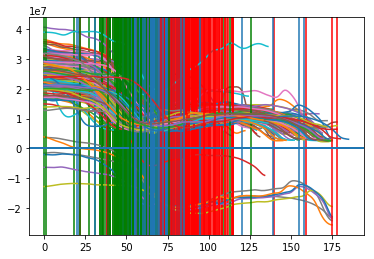

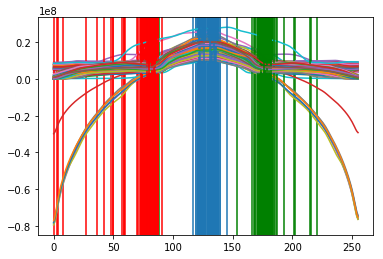

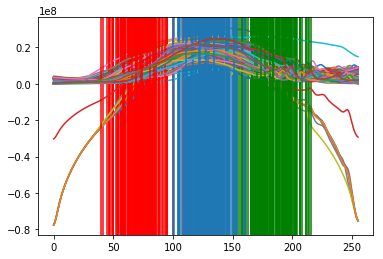

In [5]:
## Generate clipboxes
"""
In this cell, we generate clipboxes for each images based on the intensity in each direction. 
This method was designed to be fully automatic and to hopefully identify more or less the same 
region in different patients to guide the registration later. We save the clipboxes so we can
use them later, and so we can check how they look.

There is a lot of 'fudge' in this method because it doesn't work perfectly for every patient, 
but it does work most of the time!
"""
with open("clipboxData.txt", 'w') as cbd:
    for img in tqdm(os.listdir(preprocessedImages), desc="Clipboxes..."):
        image = sitk.ReadImage(os.path.join(preprocessedImages, img))
        arrayImg = sitk.GetArrayViewFromImage(image)

        mask = np.zeros_like(arrayImg)

        plt.figure(1)
        siData = gaussian_filter(np.sum(sitk.GetArrayViewFromImage(image), axis=(1,2)), 2.0)
        plt.plot(np.arange(0, image.GetSize()[2]), siData)
        # plt.plot(np.arange(0, image.GetSize()[2]), np.gradient(siData))
        neckCentre = np.argmax(1./siData[20:-20]) + 20
        centVal = np.max(1./siData[20:-20])
        try:
            upperLim = neckCentre
            for s,v in enumerate(1./siData[neckCentre:-20], neckCentre):# np.min(np.where(1./siData[neckCentre:] < 0.75*np.max(1./siData) ) ) + neckCentre
                if v < 0.75*centVal:
                    upperLim = s
                    break
        except:
            #print("unable to locate a good upper limit...")
            upperLim = neckCentre
        if upperLim == neckCentre:
            #print("Fudging upper limit...")
            upperLim += 20
        
        try:
            # lowerLim = np.min(np.where(1./siData[20:neckCentre] >= 0.25*np.max(1./siData) ) ) + 20
            lowerLim = neckCentre
            for s,v in enumerate(1./siData[20:neckCentre][::-1]):# np.min(np.where(1./siData[neckCentre:] < 0.75*np.max(1./siData) ) ) + neckCentre
                # print(s, v, v/centVal)
                if v < 0.7*centVal:
                    lowerLim = neckCentre - s
                    break
        except:
            #print("Unable to find a good lower limit...")
            lowerLim = neckCentre

        if lowerLim == neckCentre:
            #print("Fudging lower limit...")
            lowerLim -= 20
        plt.axvline(neckCentre)
        plt.axhline(0.0)
        plt.axvline(upperLim, color='r')
        plt.axvline(lowerLim, color='g')
        plt.savefig(os.path.join(validationPlots, img.split('.')[0]+"_SI.png"))
        
        # plt.plot(np.arange(0, image.GetSize()[2]), np.gradient(gaussian_filter(np.sum(sitk.GetArrayViewFromImage(image), axis=(1,2)), 2.0)))
        
        plt.figure(2)
        lrData = gaussian_filter(np.sum(sitk.GetArrayViewFromImage(image), axis=(0,1)), 2.0)
        plt.plot(np.arange(0, image.GetSize()[1]), lrData )
        plt.axvline(np.argmax(lrData))
        try:
            LRlowSide = np.clip(np.min(np.where(lrData > 0.5*np.max(lrData))) - 10, 0, 256)
        except:
            LRlowSide = np.clip(np.argmax(lrData) - 20, 0, 256)
        try:
            LRhighSide = np.clip(np.min(np.where(lrData[LRlowSide+10:] < 0.5*np.max(lrData))) + LRlowSide + 20, 0, 256)
        except:
            LRhighSide =  np.clip(np.argmax(lrData) + 20, 0, 256)
        plt.axvline(LRlowSide, color='r')
        plt.axvline(LRhighSide, color='g')
        plt.savefig(os.path.join(validationPlots, img.split('.')[0]+"_LR.png"))

        plt.figure(3)
        apData = gaussian_filter(np.sum(sitk.GetArrayViewFromImage(image), axis=(0,2)), 2.0)
        plt.plot(np.arange(0, image.GetSize()[0]), apData )
        plt.axvline(np.argmax(apData))

        try:
            APlowSide = np.clip(np.min(np.where(apData > 0.5*np.max(apData))) - 10, 0, 256)
        except:
            APlowSide = np.clip(np.argmax(apData) - 20, 0, 256)
        try:
            APhighSide = np.clip(np.min(np.where(apData[APlowSide+10:] < 0.5*np.max(apData))) + APlowSide + 20, 0, 256)
        except:
            APhighSide = np.clip(np.argmax(apData) + 20, 0, 256)
        
        plt.axvline(APlowSide, color='r')
        plt.axvline(APhighSide, color='g')
        plt.savefig(os.path.join(validationPlots, img.split('.')[0]+"_AP.png"))

        cbd.write("Image: {0}\t\tSI:\t{1}\t{2}\tLR:\t{3}\t{4}\tAP:\t{5}\t{6}\n".format(img, lowerLim, upperLim, LRlowSide, LRhighSide, APlowSide, APhighSide))
        mask[lowerLim:upperLim, LRlowSide:LRhighSide, APlowSide:APhighSide] = 1


        outputMask = sitk.GetImageFromArray(mask)
        outputMask.SetSpacing(image.GetSpacing())
        outputMask.SetOrigin(image.GetOrigin())
        outputMask.SetDirection(image.GetDirection())
        # outputMask.CopyInformation(image)


        sitk.WriteImage(outputMask, os.path.join(maskDir, img))

In [11]:
## Affine registration
"""
Affine registration allows an image to shift, rotate and scale to fit to the reference image. This cell uses simpleITK to perform
an affine registration, initialised by aligning the centre of each image's clipbox with the reference.
"""
referenceImage = sitk.ReadImage(referenceImagePath, sitk.sitkFloat32)## Read and convert to float32 for registration
referenceMask = sitk.ReadImage(referenceMaskPath)
for img in tqdm(sorted(os.listdir(preprocessedImages))[1:], desc='Affine...'):
    floating = sitk.ReadImage(os.path.join(preprocessedImages, img), sitk.sitkFloat32)
    floatingDose = sitk.ReadImage(os.path.join(preprocessedDose, img))
    # floating_bones = sitk.ConnectedThreshold(floating, [0,0,0], 1000.0, 1000, sitk.ConnectedThresholdImageFilter.FullConnectivity)
    # referenceBones = sitk.GrayscaleFillhole(referenceBones)

    floatingMask = sitk.ReadImage(os.path.join(maskDir, img))

    ## change - use masks and com initialisation

    ## Start rigid registration
    # initial_transform = sitk.CenteredTransformInitializer(referenceImage, 
    #                                                     floating, 
    #                                                     sitk.Euler3DTransform(), 
    #                                                     sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    initial_transform = sitk.CenteredTransformInitializer(referenceMask, floatingMask, sitk.AffineTransform(3), sitk.CenteredTransformInitializerFilter.MOMENTS)

    floating_resampled = sitk.Resample(floating, referenceImage, initial_transform, sitk.sitkLinear, 0.0, referenceImage.GetPixelID())
    floatingDose_resampled = sitk.Resample(floatingDose, referenceImage, initial_transform, sitk.sitkLinear, 0.0, referenceImage.GetPixelID())

    # display_images_with_alpha(image_z=55, alpha=0.5, fixed=referenceImage, moving=floating_resampled)


    ## Now do proper affine registration
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=128)
#     registration_method.SetMetricAsCorrelation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.05)
    # registration_method.SetMetricFixedMask(referenceMask)
    # registration_method.SetMetricMovingMask(floatingMask)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
    # registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    # registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    # registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    # registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    try:
        final_transform = registration_method.Execute(sitk.Cast(referenceImage, sitk.sitkFloat32), sitk.Cast(floating, sitk.sitkFloat32))
    except RuntimeError:
        print("Patient {0} failed registration".format(img))
        continue


    floating_resampled_affine = sitk.Resample(floating, referenceImage, final_transform, sitk.sitkBSpline, 0.0, referenceImage.GetPixelID())
    floatingDose_resampled_affine = sitk.Resample(floatingDose, referenceImage, final_transform, sitk.sitkBSpline, 0.0, referenceImage.GetPixelID())
    # floating_resampled_affine_bones = sitk.Resample(floating_bones, referenceImage, final_transform, sitk.sitkBSpline, 0.0, referenceImage.GetPixelID())

#     print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#     print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    floating_resampled_affine_short = sitk.Cast(floating_resampled_affine, sitk.sitkInt16)
    
    sitk.WriteImage(floating_resampled_affine_short, os.path.join(affineOutput, img))
    sitk.WriteImage(floatingDose_resampled_affine, os.path.join(affineOutputDoses, img))



Patient 0129.nii failed registration


In [12]:
## Non-rigid registration
"""
Non-rigid registration is the final step in this process where we allow the images to be deformed such that they match the 
reference as well as possible. NRR is a slow process, so this cell will take quite a while.
"""

def bspline_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsCorrelation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.025)


    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)

    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0, numberOfIterations=100)

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    
    dvf = registration_method.Execute(fixed_image, moving_image)
#     print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#     print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return dvf


for img in tqdm(sorted(os.listdir(affineOutput))[1:], desc='NRR...'):
    floating = sitk.ReadImage(os.path.join(affineOutput, img), sitk.sitkFloat32)
    floatingDose = sitk.ReadImage(os.path.join(affineOutputDoses, img))
    dvf = bspline_registration(referenceImage, floating_resampled_affine,  fixed_image_mask=referenceMask)

    floating_resampled_nrr = sitk.Resample(floating_resampled_affine, referenceImage, dvf, sitk.sitkBSpline, 0.0, referenceImage.GetPixelID())
    floatingDose_resampled_nrr = sitk.Resample(floatingDose_resampled_affine, referenceImage, dvf, sitk.sitkBSpline, 0.0, referenceImage.GetPixelID())


    floating_resampled_nrr_short = sitk.Cast(floating_resampled_nrr, sitk.sitkInt16)
    sitk.WriteImage(floating_resampled_nrr_short, os.path.join(nrrOutput, img))
    sitk.WriteImage(floatingDose_resampled_nrr, os.path.join(nrrOutputDoses, img))


    dvf_im = sitk.TransformToDisplacementField(dvf)
    sitk.WriteTransform(dvf, os.path.join(transformOutput, img.split('.')[0]+".tfm"))